# 🚀 TabPFN Time Series — Quick Start

Welcome! **TabPFN-TS** brings the power of TabPFN, a tabular foundation model, to time series forecasting.

The best part? **Zero training required** — just pass your data and get probabilistic forecasts in seconds. Let's dive in! 😉

**What we'll cover:**
1. 📈 **[Forecast time series](#univariate-forecasting)** — with just a few lines of code
2. 🔮 **[Leverage covariates](#forecasting-with-covariates)** — improve predictions when you know something about the future

## Setup

First, let's get everything ready.

We'll import the library and initialize the forecasting pipeline. Here, we provide **two inference options:**
- `TabPFNMode.LOCAL` -- Run on your machine (requires GPU for speed)
- `TabPNFMode.CLIENT` -- Use our free cloud API (recommended if no GPU)

> *Note: When using `TabPFNMode.CLIENT`, you'll be prompted to login/create an account.*

In [1]:
# !pip install tabpfn-time-series

In [2]:
import pandas as pd

from tabpfn_time_series import TabPFNTSPipeline, TabPFNMode
from tabpfn_time_series.plot import plot_forecast

In [3]:
# Initialize the pipeline
pipeline = TabPFNTSPipeline(tabpfn_mode=TabPFNMode.CLIENT)

  Welcome Back! Found existing access token, reusing it for authentication.


## 📈 Univariate Forecasting

Let's start with the most common scenario: forecasting a time series using only its historical values.

We'll use the **M4 Hourly** dataset from the famous M4 forecasting competition. The API is super simple — just pass a DataFrame with `item_id`, `timestamp` and `target` columns, and TabPFN-TS handles the rest!

Feel free to try this with your own data later. 🙂

In [4]:
# Load M4 Hourly dataset
m4_hourly_train_url = (
    "https://autogluon.s3.amazonaws.com/datasets/timeseries/m4_hourly/train.csv"
)
m4_hourly_test_url = (
    "https://autogluon.s3.amazonaws.com/datasets/timeseries/m4_hourly/test.csv"
)
m4_train_df = pd.read_csv(m4_hourly_train_url, parse_dates=["timestamp"])
m4_test_df = pd.read_csv(m4_hourly_test_url, parse_dates=["timestamp"])

In [5]:
# Select a single time series for demonstration
selected_items = m4_train_df["item_id"].unique()[:2]
context_df = m4_train_df[m4_train_df["item_id"].isin(selected_items)].copy()
test_df = m4_test_df[m4_test_df["item_id"].isin(selected_items)].copy()

print("context_df.shape", context_df.shape)
context_df.tail()

context_df.shape (1400, 3)


,item_id,timestamp,target
1395,H2,1750-01-29 23:00:00,3705.0
1396,H2,1750-01-30 00:00:00,3652.0
1397,H2,1750-01-30 01:00:00,3460.0
1398,H2,1750-01-30 02:00:00,3248.0
1399,H2,1750-01-30 03:00:00,3105.0


In [6]:
# Forecast 48 hours ahead
prediction_length = 48

pred_df = pipeline.predict_df(
    context_df=context_df,
    prediction_length=prediction_length,
)

print("pred_df.shape", pred_df.shape)
pred_df.head()

Predicting time series: 100%|██████████| 2/2 [00:00<00:00, 81.47it/s]


  Welcome Back! Found existing access token, reusing it for authentication.
  Welcome Back! Found existing access token, reusing it for authentication.


Processing: 100%|██████████| [00:01<00:00]


pred_df.shape (96, 10)


Processing: 100%|██████████| [00:00<00:00]


target         0.1         0.2         0.3  \
item_id timestamp                                                             
H1      1750-01-30 04:00:00  621.414307  605.570068  611.007996  614.951721   
        1750-01-30 05:00:00  569.247925  548.981384  556.200317  561.208252   
        1750-01-30 06:00:00  531.474304  507.569427  516.030701  521.936829   
        1750-01-30 07:00:00  504.610657  480.184937  489.267761  495.134430   
        1750-01-30 08:00:00  484.560852  458.846741  468.700256  474.942230   

                                    0.4         0.5         0.6         0.7  \
item_id timestamp                                                             
H1      1750-01-30 04:00:00  618.308899  621.414307  624.543518  627.929626   
        1750-01-30 05:00:00  565.360718  569.247925  573.172913  577.517151   
        1750-01-30 06:00:00  526.853882  531.474304  536.207214  541.440063   
        1750-01-30 07:00:00  500.009705  504.610657  509.361176  514.654358   
        1750-01-30 08:00:00  480.050232  484.560852  489.094299  494.223541   

                                    0.8         0.9  
item_id timestamp                                    
H1      1750-01-30 04:00:00  631.931030  637.444702  
        1750-01-30 05:00:00  582.869568  591.097168  
        1750-01-30 06:00:00  547.977478  557.851501  
        1750-01-30 07:00:00  521.485657  532.633850  
        1750-01-30 08:00:00  500.574707  510.611908

In [7]:
# For each item_id, slice test_df to the last prediction_length rows for easy plotting
test_df = test_df.groupby("item_id").tail(prediction_length)

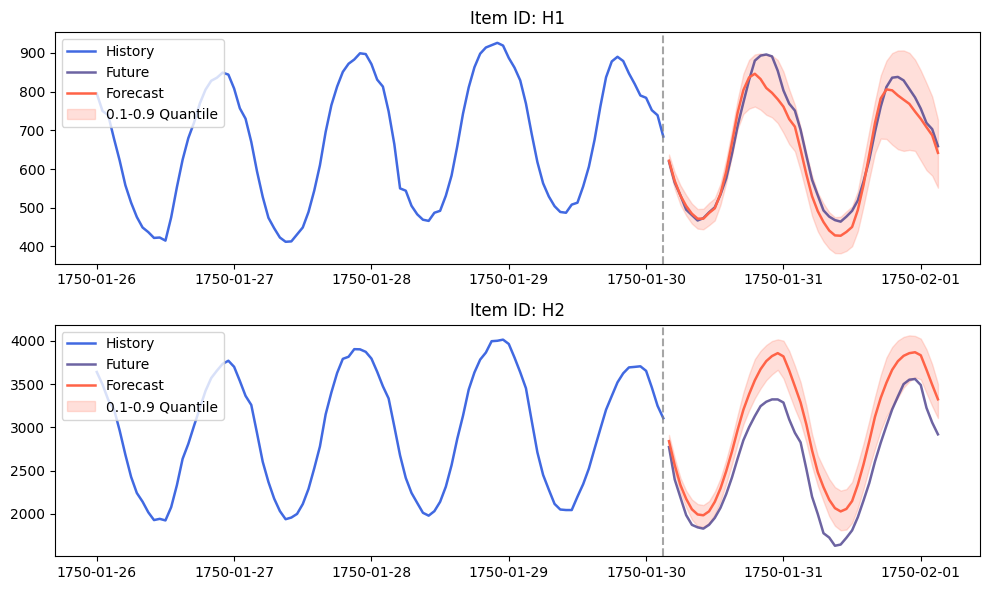

In [8]:
# Visualize: History (blue) → Forecast (orange) vs Actual future (purple)
plot_forecast(context_df, pred_df, test_df=test_df, item_ids=selected_items)

## 🔮 Forecasting with Covariates

Here's where it gets interesting! Sometimes you have additional information that can help predict the future — things like weather forecasts, scheduled events, or economic indicators. These are called **covariates**.

Let's forecast **electricity prices** — notoriously tricky to predict! But we have some useful covariates:
- **Load forecasts** — predicted electricity demand
- **Fuel prices** — coal and gas prices that affect generation costs

To use covariates, simply include them as extra columns in your data and provide a `future_df` with their known future values. That's it!

In [9]:
# Load Electricity Price dataset
train_url = "https://autogluon.s3.amazonaws.com/datasets/timeseries/electricity_price/train.parquet"
test_url = "https://autogluon.s3.amazonaws.com/datasets/timeseries/electricity_price/test.parquet"

elec_train_df = pd.read_parquet(train_url)
elec_test_df = pd.read_parquet(test_url)

print(f"Train shape: {elec_train_df.shape}")
print(f"Test shape: {elec_test_df.shape}")
print(f"\nColumns: {elec_train_df.columns.tolist()}")
elec_train_df.head()

Train shape: (51936, 5)
Test shape: (24, 5)

Columns: ['id', 'timestamp', 'target', 'Ampirion Load Forecast', 'PV+Wind Forecast']


,id,timestamp,target,Ampirion Load Forecast,PV+Wind Forecast
0,DE,2012-01-09 00:00:00,34.970001,16382.00,3569.527588
1,DE,2012-01-09 01:00:00,33.430000,15410.50,3315.274902
2,DE,2012-01-09 02:00:00,32.740002,15595.00,3107.307617
3,DE,2012-01-09 03:00:00,32.459999,16521.00,2944.620117
4,DE,2012-01-09 04:00:00,32.500000,17700.75,2897.149902


In [10]:
# Rename columns to match expected format
# The pipeline expects: timestamp, target, item_id (optional), and any covariate columns
elec_train_df = elec_train_df.rename(columns={"id": "item_id"})
elec_test_df = elec_test_df.rename(columns={"id": "item_id"})
covariate_cols = ["Ampirion Load Forecast", "PV+Wind Forecast"]

# Select a single region for demonstration
selected_region = elec_train_df["item_id"].unique()[0]
context_df = elec_train_df[elec_train_df["item_id"] == selected_region].copy()
test_df = elec_test_df[elec_test_df["item_id"] == selected_region].copy()

print(f"Region: {selected_region}")
print(f"Context length: {len(context_df)}")
print(f"Test length: {len(test_df)}")

Region: DE
Context length: 51936
Test length: 24


In [11]:
# Prepare future_df with covariates (excluding target)
future_df = test_df.drop(columns=["target"])

print("Future covariates:")
future_df.head()

Future covariates:


,item_id,timestamp,Ampirion Load Forecast,PV+Wind Forecast
0,DE,2017-12-12 00:00:00,20483.00,22284.005859
1,DE,2017-12-12 01:00:00,19849.75,22878.673828
2,DE,2017-12-12 02:00:00,19638.25,23632.283203
3,DE,2017-12-12 03:00:00,19895.25,24635.945312
4,DE,2017-12-12 04:00:00,20338.00,25584.935547


In [12]:
# Forecast with covariates
pred_w_covariates_df = pipeline.predict_df(
    context_df=context_df,
    future_df=future_df,
)
pred_without_covariates_df = pipeline.predict_df(
    context_df=context_df.drop(columns=covariate_cols),
    future_df=future_df.drop(columns=covariate_cols),
)

/Users/liam/priorlabs/set3/tabpfn-time-series/tabpfn_time_series/features/feature_transformer.py:24: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  tsdf = pd.concat([train_tsdf, test_tsdf])
Processing: 100%|██████████| [00:01<00:00]/1 [00:00<?, ?it/s]
Predicting time series: 100%|██████████| 1/1 [00:03<00:00,  3.81s/it]
/Users/liam/priorlabs/set3/tabpfn-time-series/tabpfn_time_series/features/feature_transformer.py:24: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  tsdf = pd.concat([train_tsdf, te

### 🤔 Do covariates actually help?

Let's find out! We'll compare forecasts **without** and **with** covariates side by side.

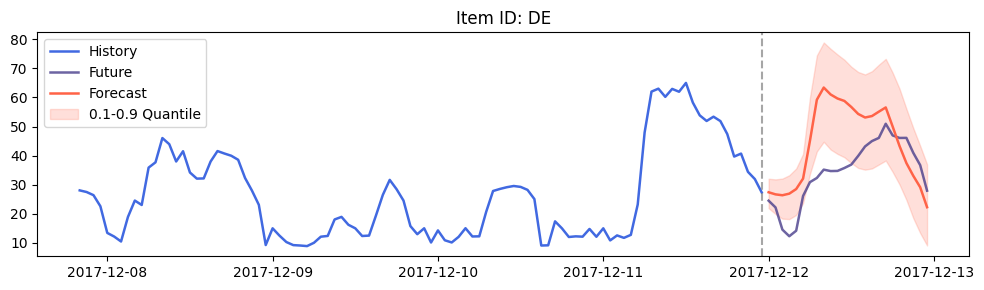

In [13]:
# Without covariates: using only historical prices
plot_forecast(
    context_df, pred_without_covariates_df, test_df=test_df, item_ids=[selected_region]
)

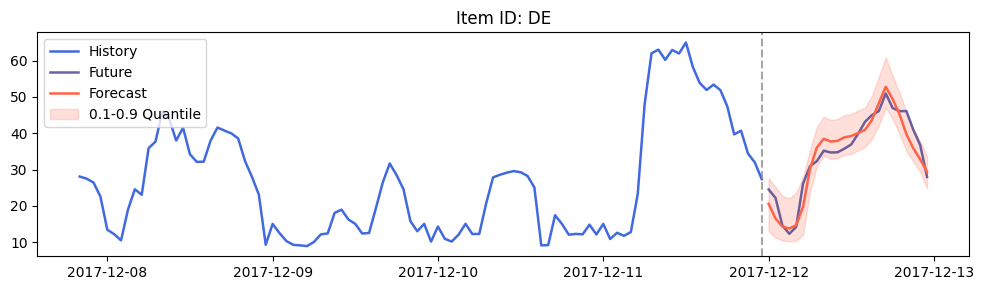

In [14]:
# With covariates: leveraging load forecasts and fuel prices
plot_forecast(
    context_df, pred_w_covariates_df, test_df=test_df, item_ids=[selected_region]
)

## 🎉 What's Next?

You've just seen a walkthrough on using `TabPFNTSPipeline`!

**Ready to go deeper?**
- 🔍 **[How TabPFN-TS Works](examples/how-it-works.ipynb)** — Understand the methodology step-by-step: data representation, feature engineering, and how zero-shot prediction actually works
- 🧪 **Try your own data** — Just format it with `item_id`, `timestamp`, and `target` columns

**We're not perfect, and we'd love your feedback!**
- 💬 Join our [Discord community](https://discord.gg/VJRuU3bSxt)
- 🐛 Open an issue on [GitHub](https://github.com/PriorLabs/tabpfn-time-series)

Thanks for trying TabPFN-TS! 🙏